In [1]:
import torch
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import numpy as np
import wandb

import utils

import os
import sys
module_paths =  [
    os.path.abspath(os.path.join('ronin/source'))  # RoNIN
]
for module_path in module_paths:
    if module_path not in sys.path:
        sys.path.append(module_path)

import data_glob_speed
import data_ridi
import cnn_ae_model


# WANDB API Key: eefeec3d5632912a6bb9112f48d2dde3ca6e0658
wandb.login()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

wandb: Currently logged in as: ansonw. Use `wandb login --relogin` to force relogin


cuda


# Data loading

In [2]:
DATA_ROOT_DIR = 'datasets'
with open('datasets/self_sup_ronin_train_list.txt') as f:
    ronin_data_list = [s.strip().split(',' or ' ')[0] for s in f.readlines() if len(s) > 0 and s[0] != '#']
with open('datasets/self_sup_ridi_train_list.txt') as f:
    ridi_data_list = [s.strip().split(',' or ' ')[0] for s in f.readlines() if len(s) > 0 and s[0] != '#']

# Each item in the dataset is a (feature, target, seq_id, frame_id) tuple.
# Each feature is a 6x200 array. Rows 0-2 are gyro, and rows 3-5 are accel (non gravity subtracted).
# Both gyro and accels are in a gravity-aligned world frame (arbitrary yaw, but consistent throughout
# the 200 frames)
ronin_train_dataset = data_glob_speed.StridedSequenceDataset(data_glob_speed.GlobSpeedSequence,
                                                             DATA_ROOT_DIR,
                                                             ronin_data_list,
                                                             cache_path='datasets/cache')
ridi_train_dataset = data_glob_speed.StridedSequenceDataset(data_ridi.RIDIGlobSpeedSequence,
                                                            DATA_ROOT_DIR,
                                                            ridi_data_list,
                                                            cache_path='datasets/cache')
self_sup_train_dataset = torch.utils.data.ConcatDataset([ronin_train_dataset, ridi_train_dataset])

batch_size = 128
self_sup_train_loader = DataLoader(self_sup_train_dataset, batch_size=batch_size, shuffle=True)

In [3]:
# Params for 1st try
# latent_dim = 64
# first_chan_size = 64
# last_chan_size = 512
# fc_dim = 256

latent_dim = 128
first_chan_size = 32
last_chan_size = 128
fc_dim = 128
model = cnn_ae_model.CnnAutoencoder(feature_dim=6,
                             latent_dim=latent_dim,
                             first_channel_size=first_chan_size,
                             last_channel_size=last_chan_size,
                             fc_dim=fc_dim).to(device)

# Train

In [4]:
should_train = True
epoch_offset = 0

In [5]:
EPOCHS=500
lr = 1e-4
weight_decay = 1e-5
if should_train:
    run = wandb.init(
        # Set the project where this run will be logged
        project="CnnAe-Self-Sup-RONIN-RIDI",
        # Track hyperparameters and run metadata
        config={
            "latent_dim": latent_dim,
            "first_chan_size": first_chan_size,
            "last_chan_size": last_chan_size,
            "fc_dim": fc_dim,
            "batch_size": batch_size,
            "lr": lr,
            "weight_decay": weight_decay
    })
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    with tqdm(total=EPOCHS) as pbar:
        best_nelbo = np.inf
        for epoch in range(epoch_offset + 1, epoch_offset + EPOCHS):
            train_losses = []
            for batch_id, (feat, _, _, _) in enumerate(self_sup_train_loader):
                feat = feat.to(device)
                optimizer.zero_grad()
                feat_recon = model(feat)

                loss = torch.nn.functional.mse_loss(feat_recon, feat)
                loss.backward()
                optimizer.step()

                train_losses.append(loss.cpu().detach().numpy())
                pbar.set_postfix(
                    loss='{:.2e}'.format(loss)
                )

            train_loss_avg = np.average(train_losses)
            run.log({
                "loss": train_loss_avg
            })

            if train_loss_avg < best_nelbo:
                best_nelbo = train_loss_avg
                utils.save_model_by_name(model, epoch, True)

            pbar.update(1)

  0%|          | 0/500 [00:00<?, ?it/s]

Saved to checkpoints/CnnVae_feat=6_latent=128_firstChan=32_lastChan=128_fcDim=128/model-00001.pt
Best model so far:  checkpoints/CnnVae_feat=6_latent=128_firstChan=32_lastChan=128_fcDim=128/model-00001.pt
Saved to checkpoints/CnnVae_feat=6_latent=128_firstChan=32_lastChan=128_fcDim=128/model-00002.pt
Best model so far:  checkpoints/CnnVae_feat=6_latent=128_firstChan=32_lastChan=128_fcDim=128/model-00002.pt
Saved to checkpoints/CnnVae_feat=6_latent=128_firstChan=32_lastChan=128_fcDim=128/model-00003.pt
Best model so far:  checkpoints/CnnVae_feat=6_latent=128_firstChan=32_lastChan=128_fcDim=128/model-00003.pt
Saved to checkpoints/CnnVae_feat=6_latent=128_firstChan=32_lastChan=128_fcDim=128/model-00004.pt
Best model so far:  checkpoints/CnnVae_feat=6_latent=128_firstChan=32_lastChan=128_fcDim=128/model-00004.pt
Saved to checkpoints/CnnVae_feat=6_latent=128_firstChan=32_lastChan=128_fcDim=128/model-00005.pt
Best model so far:  checkpoints/CnnVae_feat=6_latent=128_firstChan=32_lastChan=128_

# VAE Reconstruction eval

In [4]:
utils.load_model_by_name(model, epoch=496)

Loaded from checkpoints/CnnVae_feat=6_latent=128_firstChan=32_lastChan=128_fcDim=128/model-00496.pt


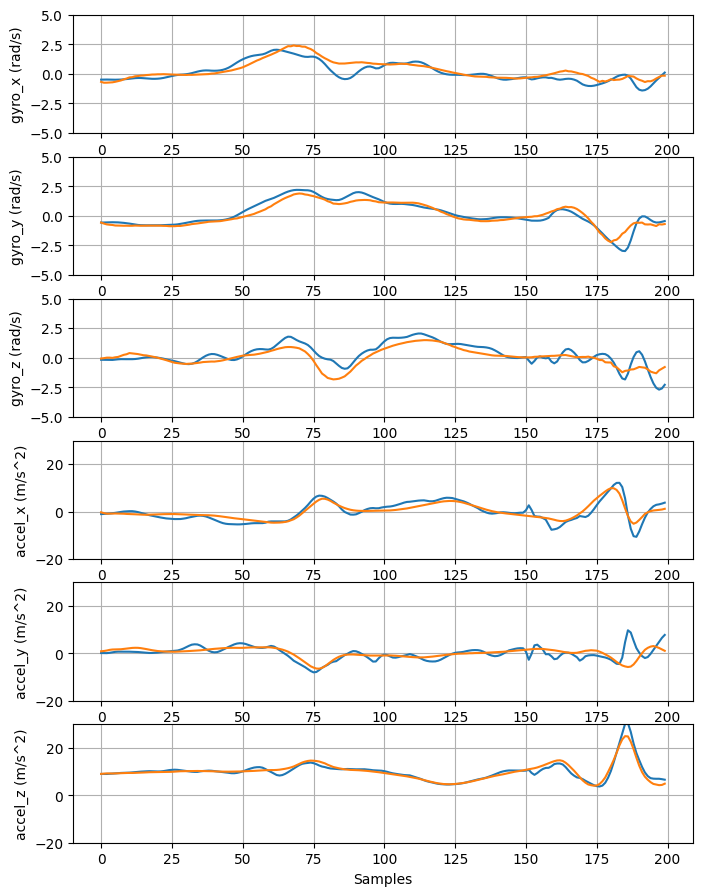

In [15]:
for batch_id, (feat, _, _, _) in enumerate(self_sup_train_loader):
    feat = feat.to(device)
    out_feat = model(feat)
    break

batch_id = 30
x_axis = np.arange(200)
plt.figure(figsize=(8,12))
titles = ['gyro_x (rad/s)', 'gyro_y (rad/s)', 'gyro_z (rad/s)', 'accel_x (m/s^2)', 'accel_y (m/s^2)', 'accel_z (m/s^2)']
for i in range(6):
    plt.subplot(6, 1, i+1)
    plt.plot(x_axis, feat[batch_id, i, :].squeeze().cpu().detach().numpy())
    plt.plot(x_axis, out_feat[batch_id, i, :].squeeze().cpu().detach().numpy())
    if i < 3:
        plt.ylim(-5, 5)
    else:
        plt.ylim(-20, 30)
    plt.ylabel(titles[i])
    plt.xlabel('Samples')
    plt.grid(True)
plt.subplots_adjust(top=0.8)
plt.show()